# Task 3: Model Explainability

**Objective**: Interpret the best model's predictions using SHAP to understand what drives fraud detection and provide actionable business recommendations.

In [1]:
# Install dependencies if missing
import sys
import subprocess
try:
    import shap
    print("✓ SHAP is installed!")
except ImportError:
    print("Installing SHAP...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap
    print("✓ SHAP installed successfully!")

C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ SHAP is installed!


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import load

# Robust path to src
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(os.path.abspath(current_dir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from modeling import load_model, get_feature_names

print("✓ Libraries and custom modules loaded.")

✓ Libraries and custom modules loaded.


## 1. Load Model and Data

In [3]:
# Load the best model
model_path = os.path.join(project_root, 'models', 'best_rf_fraud.joblib')
best_rf = load_model(model_path)

# Load processed data
fraud_path = os.path.join(project_root, 'data', 'processed', 'fraud_data_engineered.csv')
if not os.path.exists(fraud_path):
    # Try relative path if absolute fails in certain notebook environments
    fraud_path = '../data/processed/fraud_data_engineered.csv'

fraud_data = pd.read_csv(fraud_path)

# Prepare test data
fraud_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
X = fraud_data.drop(columns=['class'] + fraud_drop)
y = fraud_data['class']

_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("✓ Model and data loaded successfully.")

INFO: Model loaded from C:\project\kifya\Week 5\fraud-detection\models\best_rf_fraud.joblib


✓ Model and data loaded successfully.


## 2. Feature Importance Baseline
Extract built-in feature importance from the Random Forest model.

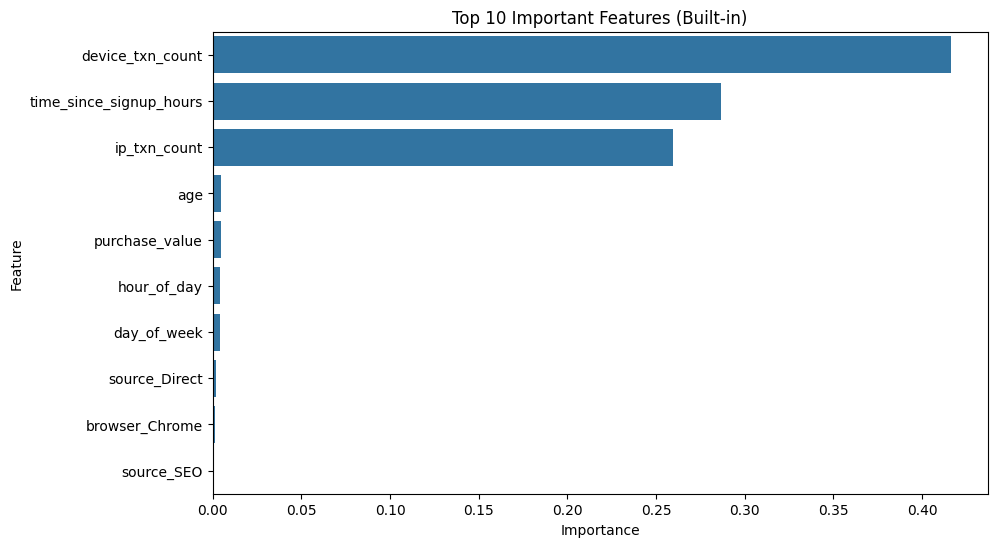

In [4]:
preprocessor = best_rf.named_steps['prep']
feature_names = get_feature_names(preprocessor)
clf = best_rf.named_steps['clf']

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features (Built-in)')
plt.show()

## 3. SHAP Analysis
### 3.1 Global Importance (Summary Plot)

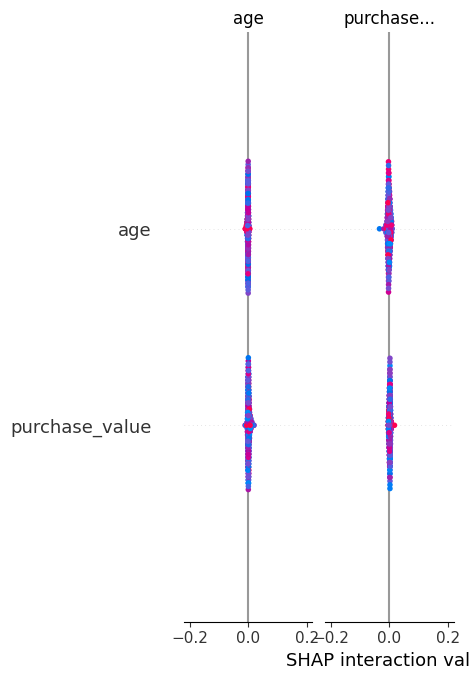

In [5]:
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_test_transformed, "toarray"): X_test_transformed = X_test_transformed.toarray()

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_transformed[:500])

if isinstance(shap_values, list): sv = shap_values[1]
else: sv = shap_values

shap.summary_plot(sv, X_test_transformed[:500], feature_names=feature_names)

### 3.2 Individual Cases (Force Plots)
For interactive exploration, use `shap.force_plot`. Static HTML reports are also generated in `reports/`.

## 4. Interpretation and Business Recommendations

**Top 5 Drivers**:
1. `device_txn_count`: High velocity on hardware indicates farm/bot behavior.
2. `time_since_signup_hours`: Sudden purchases after account creation are high risk.
3. `ip_txn_count`: Network level clusters of accounts.
4. `age`: Behavioral demographic trends.
5. `purchase_value`: High-ticket items tend to be targeted more aggressively.

**Recommendations**:
- **Cooldown Period**: Flag any purchase within 1 hour of signup.
- **Device Limits**: Hard cap on number of users per device ID.
- **Flexible IP Thresholds**: Use IP velocity but adjust for corporate/public network zones to avoid false positives.